# Vollständige Analyse: DSS-induzierte Darmentzündung bei Mäusen


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

# Stil setzen
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Daten laden und explorieren

In [4]:
# Daten laden
df = pd.read_csv('testdata.txt', sep='\t')
print("Datensatz geladen:")
print(df.head())
print(f"\nShape: {df.shape}")
print(f"\nAnzahl Tiere: {df['id'].nunique()}")
print(f"DSS-Dosen: {sorted(df['DSS'].unique())}")

Datensatz geladen:
        id  DSS  day    bwc    vwr
0  SvBi029    1    0  100.0   79.3
1  SvBi029    1    1  103.5  125.4
2  SvBi029    1    2  102.6   95.8
3  SvBi029    1    3  100.9   57.1
4  SvBi029    1    4  101.3   69.7

Shape: (813, 5)

Anzahl Tiere: 62
DSS-Dosen: [np.int64(0), np.int64(1), np.int64(2)]


In [5]:
# Grundlegende Statistik
print("\n=== Deskriptive Statistik ===")
print(df.describe())

# Tiere pro Gruppe
print("\n=== Tiere pro DSS-Gruppe ===")
print(df.groupby('DSS')['id'].nunique())


=== Deskriptive Statistik ===
              DSS         day         bwc         vwr
count  813.000000  813.000000  813.000000  813.000000
mean     0.859779    6.238622   98.707872   79.689791
std      0.795627    4.006415    4.855248   28.152900
min      0.000000    0.000000   80.000000    0.800000
25%      0.000000    3.000000   97.400000   64.700000
50%      1.000000    6.000000   99.500000   86.100000
75%      2.000000   10.000000  101.400000   98.400000
max      2.000000   13.000000  121.600000  156.400000

=== Tiere pro DSS-Gruppe ===
DSS
0    23
1    22
2    17
Name: id, dtype: int64


# Charakterisierung beider Variablen einzeln
## Dosisabhängige Unterschiede über die Zeit

In [6]:
# Aggregation nach DSS und Tag
stats_by_day = df.groupby(['DSS', 'day']).agg({
    'bwc': ['mean', 'std', 'sem'],
    'vwr': ['mean', 'std', 'sem'],
    'id': 'count'
}).reset_index()

stats_by_day.columns = ['DSS', 'day', 'bwc_mean', 'bwc_std', 'bwc_sem', 
                         'vwr_mean', 'vwr_std', 'vwr_sem', 'n']

print("\n=== Statistische Zusammenfassung nach Gruppe und Tag ===")
print(stats_by_day.head(20))


=== Statistische Zusammenfassung nach Gruppe und Tag ===
    DSS  day    bwc_mean   bwc_std   bwc_sem    vwr_mean    vwr_std   vwr_sem  \
0     0    0  100.000000  0.000000  0.000000   81.708696  17.795426  3.710603   
1     0    1   98.734783  2.011017  0.419326   91.747826  14.746244  3.074804   
2     0    2   99.630435  2.543876  0.530435   96.495652  16.092813  3.355583   
3     0    3   99.678261  2.302559  0.480117   94.160870  10.414838  2.171644   
4     0    4   98.843478  2.682574  0.559355   92.082609  19.623216  4.091723   
5     0    5  100.304348  2.769883  0.577561   73.982609  22.917176  4.778562   
6     0    6   98.952174  3.141926  0.655137   87.939130  21.018947  4.382753   
7     0    7  100.082609  2.946285  0.614343   91.039130  21.269755  4.435051   
8     0    8  100.043478  4.708293  0.981747   91.082609  22.755192  4.744786   
9     0    9   99.104348  3.921210  0.817629   88.156522  18.917544  3.944581   
10    0   10  100.295652  3.231025  0.673715   91.2

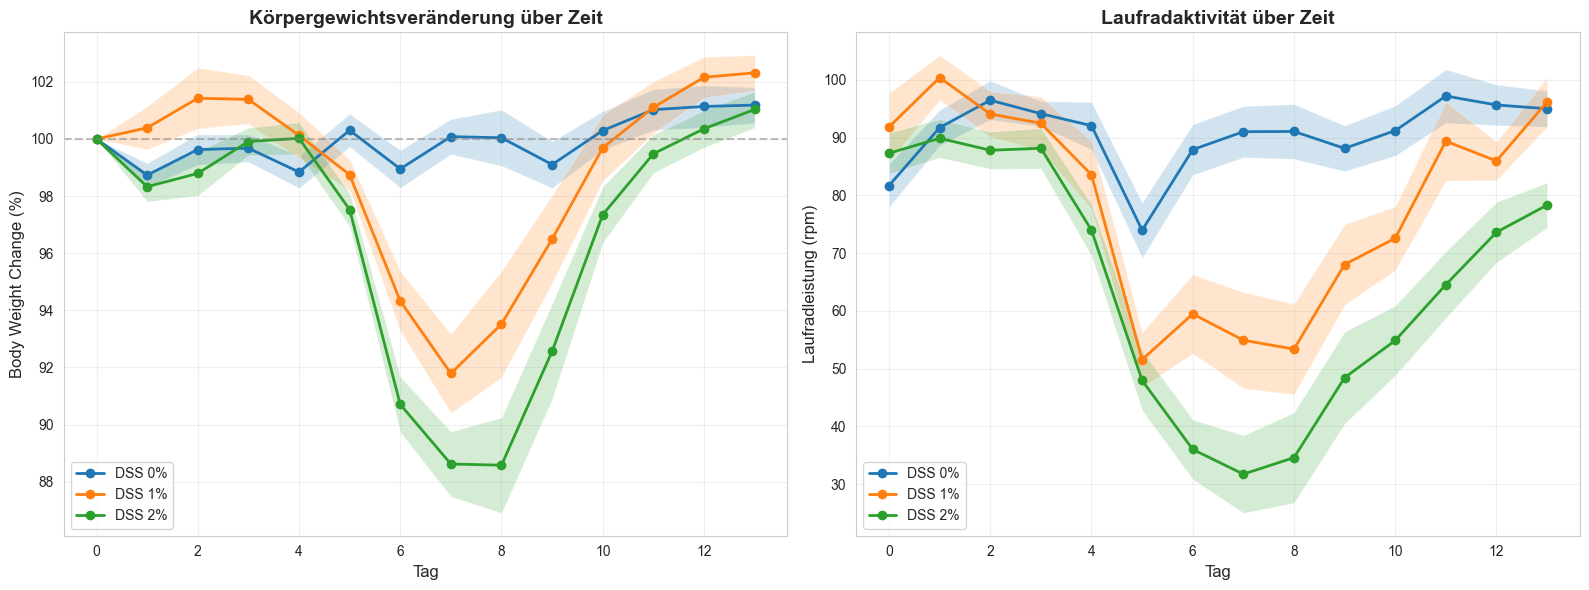

In [7]:
# Visualisierung 1: Body Weight Change über Zeit
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BWC über Zeit
for dss in sorted(df['DSS'].unique()):
    data = stats_by_day[stats_by_day['DSS'] == dss]
    axes[0].plot(data['day'], data['bwc_mean'], marker='o', label=f'DSS {dss}%', linewidth=2)
    axes[0].fill_between(data['day'], 
                          data['bwc_mean'] - data['bwc_sem'],
                          data['bwc_mean'] + data['bwc_sem'],
                          alpha=0.2)

axes[0].set_xlabel('Tag', fontsize=12)
axes[0].set_ylabel('Body Weight Change (%)', fontsize=12)
axes[0].set_title('Körpergewichtsveränderung über Zeit', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Baseline')

# VWR über Zeit
for dss in sorted(df['DSS'].unique()):
    data = stats_by_day[stats_by_day['DSS'] == dss]
    axes[1].plot(data['day'], data['vwr_mean'], marker='o', label=f'DSS {dss}%', linewidth=2)
    axes[1].fill_between(data['day'], 
                          data['vwr_mean'] - data['vwr_sem'],
                          data['vwr_mean'] + data['vwr_sem'],
                          alpha=0.2)

axes[1].set_xlabel('Tag', fontsize=12)
axes[1].set_ylabel('Laufradleistung (rpm)', fontsize=12)
axes[1].set_title('Laufradaktivität über Zeit', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_zeitverlaeufe.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Statistische Tests für dosisabhängige Unterschiede zu verschiedenen Zeitpunkten
print("\n=== STATISTISCHE TESTS: Dosisabhängige Unterschiede ===")
print("\nKruskal-Wallis Tests für verschiedene Zeitpunkte:")
print("="*70)

test_days = [5, 8, 13]  # Kritische Zeitpunkte

for day in test_days:
    day_data = df[df['day'] == day]
    
    # Gruppen für den Test
    groups_bwc = [day_data[day_data['DSS'] == dss]['bwc'].values 
                  for dss in sorted(df['DSS'].unique())]
    groups_vwr = [day_data[day_data['DSS'] == dss]['vwr'].values 
                  for dss in sorted(df['DSS'].unique())]
    
    # Kruskal-Wallis Test (nicht-parametrisch)
    h_bwc, p_bwc = stats.kruskal(*groups_bwc)
    h_vwr, p_vwr = stats.kruskal(*groups_vwr)
    
    print(f"\nTag {day}:")
    print(f"  Body Weight Change: H={h_bwc:.2f}, p={p_bwc:.4f} {'***' if p_bwc < 0.001 else '**' if p_bwc < 0.01 else '*' if p_bwc < 0.05 else 'n.s.'}")
    print(f"  Laufradleistung:    H={h_vwr:.2f}, p={p_vwr:.4f} {'***' if p_vwr < 0.001 else '**' if p_vwr < 0.01 else '*' if p_vwr < 0.05 else 'n.s.'}")


=== STATISTISCHE TESTS: Dosisabhängige Unterschiede ===

Kruskal-Wallis Tests für verschiedene Zeitpunkte:

Tag 5:
  Body Weight Change: H=11.37, p=0.0034 **
  Laufradleistung:    H=14.31, p=0.0008 ***

Tag 8:
  Body Weight Change: H=18.78, p=0.0001 ***
  Laufradleistung:    H=23.17, p=0.0000 ***

Tag 13:
  Body Weight Change: H=2.32, p=0.3136 n.s.
  Laufradleistung:    H=9.15, p=0.0103 *


In [9]:
# Post-hoc Tests: Paarweise Vergleiche für Tag 8 (Höhepunkt der Entzündung)
from scipy.stats import mannwhitneyu

print("\n=== POST-HOC: Paarweise Vergleiche (Mann-Whitney U) an Tag 8 ===")
print("="*70)

day8_data = df[df['day'] == 8]
dss_levels = sorted(df['DSS'].unique())

for i, dss1 in enumerate(dss_levels):
    for dss2 in dss_levels[i+1:]:
        group1_bwc = day8_data[day8_data['DSS'] == dss1]['bwc'].values
        group2_bwc = day8_data[day8_data['DSS'] == dss2]['bwc'].values
        group1_vwr = day8_data[day8_data['DSS'] == dss1]['vwr'].values
        group2_vwr = day8_data[day8_data['DSS'] == dss2]['vwr'].values
        
        u_bwc, p_bwc = mannwhitneyu(group1_bwc, group2_bwc, alternative='two-sided')
        u_vwr, p_vwr = mannwhitneyu(group1_vwr, group2_vwr, alternative='two-sided')
        
        print(f"\nDSS {dss1}% vs DSS {dss2}%:")
        print(f"  BWC: U={u_bwc:.1f}, p={p_bwc:.4f} {'***' if p_bwc < 0.001 else '**' if p_bwc < 0.01 else '*' if p_bwc < 0.05 else 'n.s.'}")
        print(f"  VWR: U={u_vwr:.1f}, p={p_vwr:.4f} {'***' if p_vwr < 0.001 else '**' if p_vwr < 0.01 else '*' if p_vwr < 0.05 else 'n.s.'}")


=== POST-HOC: Paarweise Vergleiche (Mann-Whitney U) an Tag 8 ===

DSS 0% vs DSS 1%:
  BWC: U=320.5, p=0.0103 *
  VWR: U=359.5, p=0.0004 ***

DSS 0% vs DSS 2%:
  BWC: U=296.5, p=0.0000 ***
  VWR: U=299.0, p=0.0000 ***

DSS 1% vs DSS 2%:
  BWC: U=180.0, p=0.0902 n.s.
  VWR: U=171.5, p=0.1663 n.s.


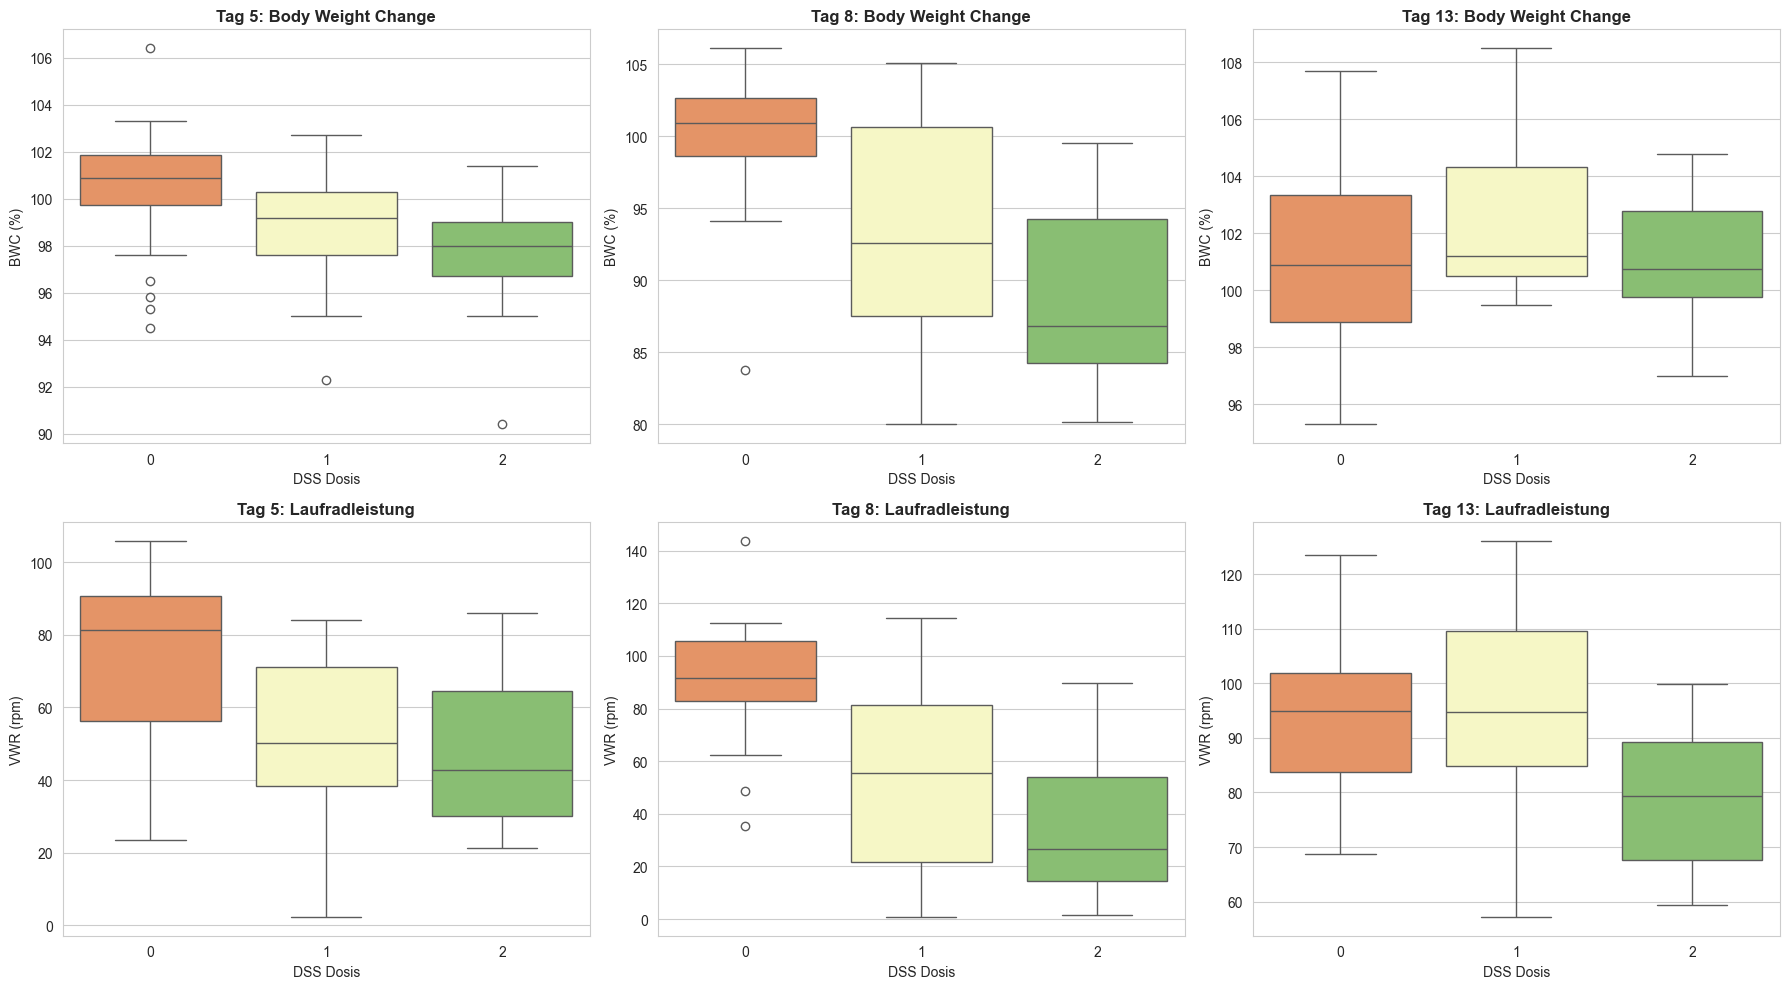

In [10]:
# Boxplots für kritische Zeitpunkte
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, day in enumerate([5, 8, 13]):
    day_data = df[df['day'] == day]
    
    # BWC Boxplot
    sns.boxplot(data=day_data, x='DSS', y='bwc', ax=axes[0, idx], palette='RdYlGn')
    axes[0, idx].set_title(f'Tag {day}: Body Weight Change', fontweight='bold')
    axes[0, idx].set_xlabel('DSS Dosis')
    axes[0, idx].set_ylabel('BWC (%)')
    
    # VWR Boxplot
    sns.boxplot(data=day_data, x='DSS', y='vwr', ax=axes[1, idx], palette='RdYlGn')
    axes[1, idx].set_title(f'Tag {day}: Laufradleistung', fontweight='bold')
    axes[1, idx].set_xlabel('DSS Dosis')
    axes[1, idx].set_ylabel('VWR (rpm)')

plt.tight_layout()
plt.savefig('02_boxplots_zeitpunkte.png', dpi=300, bbox_inches='tight')
plt.show()

# Machine Learning Classifier für Belastungskategorien
## 2.1 Clustering zur objektiven Kategorienfindung

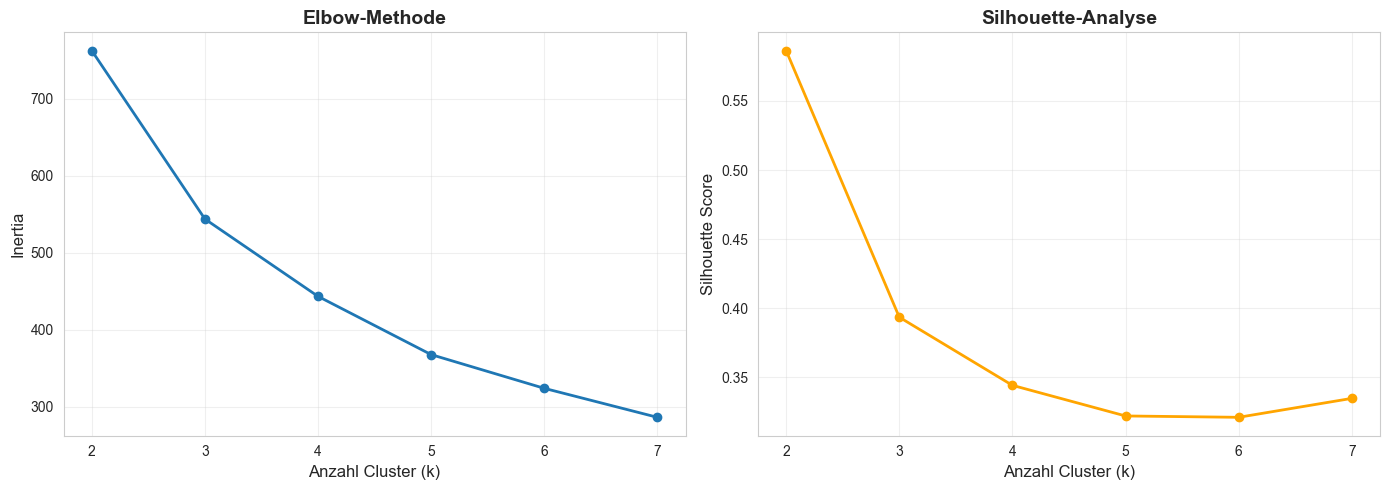


Optimale Cluster-Anzahl: k=3 (höchster Silhouette Score: 0.586)


In [11]:
# Vorbereitung der Features
X_features = df[['bwc', 'vwr']].values

# Standardisierung für Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Elbow-Methode zur Bestimmung der optimalen Cluster-Anzahl
inertias = []
silhouette_scores = []
K_range = range(2, 8)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2)
axes[0].set_xlabel('Anzahl Cluster (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow-Methode', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Anzahl Cluster (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette-Analyse', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_cluster_optimierung.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOptimale Cluster-Anzahl: k=3 (höchster Silhouette Score: {max(silhouette_scores):.3f})")

In [12]:
# K-Means mit k=3 durchführen
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Cluster-Zentren zurücktransformieren
cluster_centers = scaler.inverse_transform(kmeans_final.cluster_centers_)

print("\n=== Cluster-Zentren (unstandardisiert) ===")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: BWC={center[0]:.1f}%, VWR={center[1]:.1f} rpm")

# Cluster sortieren nach Schweregrad (niedrigste BWC + VWR = höchster Schweregrad)
severity_score = cluster_centers[:, 0] + cluster_centers[:, 1]
cluster_mapping = np.argsort(severity_score)  # Sortiert nach aufsteigendem Score

# Mapping: niedrigster Score (schwerste Belastung) = 2
severity_mapping = {cluster_mapping[0]: 2, cluster_mapping[1]: 1, cluster_mapping[2]: 0}
severity_labels = np.array([severity_mapping[c] for c in cluster_labels])

df['severity_clustered'] = severity_labels

print("\n=== Schweregrad-Mapping ===")
for original, mapped in severity_mapping.items():
    center = cluster_centers[original]
    print(f"Cluster {original} → Severity {mapped}: BWC={center[0]:.1f}%, VWR={center[1]:.1f} rpm")

print("\n=== Verteilung der Cluster-basierten Severity-Labels ===")
print(df['severity_clustered'].value_counts().sort_index())


=== Cluster-Zentren (unstandardisiert) ===
Cluster 0: BWC=100.3%, VWR=98.5 rpm
Cluster 1: BWC=88.2%, VWR=29.9 rpm
Cluster 2: BWC=99.5%, VWR=61.9 rpm

=== Schweregrad-Mapping ===
Cluster 1 → Severity 2: BWC=88.2%, VWR=29.9 rpm
Cluster 2 → Severity 1: BWC=99.5%, VWR=61.9 rpm
Cluster 0 → Severity 0: BWC=100.3%, VWR=98.5 rpm

=== Verteilung der Cluster-basierten Severity-Labels ===
severity_clustered
0    475
1    247
2     91
Name: count, dtype: int64


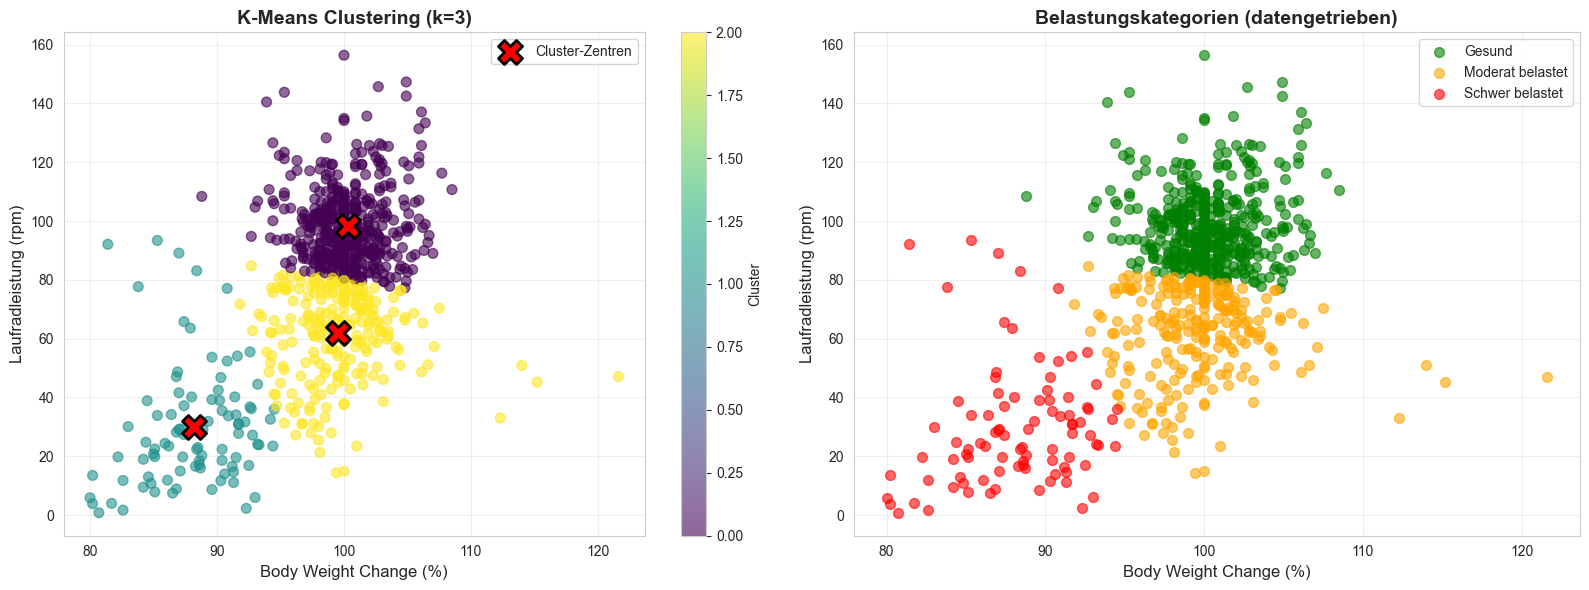

In [13]:
# Visualisierung der Cluster
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cluster-Zuordnung
scatter1 = axes[0].scatter(df['bwc'], df['vwr'], c=cluster_labels, 
                           cmap='viridis', alpha=0.6, s=50)
axes[0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                c='red', marker='X', s=300, edgecolors='black', linewidths=2,
                label='Cluster-Zentren')
axes[0].set_xlabel('Body Weight Change (%)', fontsize=12)
axes[0].set_ylabel('Laufradleistung (rpm)', fontsize=12)
axes[0].set_title('K-Means Clustering (k=3)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Severity-Labels
colors = {0: 'green', 1: 'orange', 2: 'red'}
for severity in [0, 1, 2]:
    mask = df['severity_clustered'] == severity
    label = ['Gesund', 'Moderat belastet', 'Schwer belastet'][severity]
    axes[1].scatter(df.loc[mask, 'bwc'], df.loc[mask, 'vwr'], 
                    c=colors[severity], label=label, alpha=0.6, s=50)

axes[1].set_xlabel('Body Weight Change (%)', fontsize=12)
axes[1].set_ylabel('Laufradleistung (rpm)', fontsize=12)
axes[1].set_title('Belastungskategorien (datengetrieben)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Training verschiedener Classifier

In [14]:
# Daten vorbereiten
X = df[['bwc', 'vwr']].values
y = df['severity_clustered'].values

# Train/Test Split (stratifiziert wegen Klassenimbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardisierung
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

print(f"Training Set: {X_train.shape[0]} Samples")
print(f"Test Set: {X_test.shape[0]} Samples")
print(f"\nKlassenverteilung im Training Set:")
print(pd.Series(y_train).value_counts().sort_index())

Training Set: 650 Samples
Test Set: 163 Samples

Klassenverteilung im Training Set:
0    380
1    197
2     73
Name: count, dtype: int64


In [15]:
# Drei verschiedene Classifier trainieren
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

print("\n=== TRAINING DER CLASSIFIER ===")
print("="*70)

for name, clf in classifiers.items():
    # Training
    clf.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test_scaled)
    
    # Cross-Validation (5-Fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    
    # Metriken berechnen
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'model': clf,
        'y_pred': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy:  {accuracy:.3f}")
    print(f"  CV Accuracy:    {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"  Precision:      {precision:.3f}")
    print(f"  Recall:         {recall:.3f}")
    print(f"  F1-Score:       {f1:.3f}")


=== TRAINING DER CLASSIFIER ===

Logistic Regression:
  Test Accuracy:  0.994
  CV Accuracy:    0.985 ± 0.013
  Precision:      0.994
  Recall:         0.994
  F1-Score:       0.994

SVM (Linear):
  Test Accuracy:  0.988
  CV Accuracy:    0.989 ± 0.004
  Precision:      0.988
  Recall:         0.988
  F1-Score:       0.988

Random Forest:
  Test Accuracy:  0.975
  CV Accuracy:    0.982 ± 0.012
  Precision:      0.976
  Recall:         0.975
  F1-Score:       0.976


In [16]:
# Bester Classifier auswählen
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\n{'='*70}")
print(f"BESTER CLASSIFIER: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.3f}")
print(f"{'='*70}")


BESTER CLASSIFIER: Logistic Regression
Test Accuracy: 0.994


# Umfassende statistische Beschreibung des Classifiers
## 3.1 Confusion Matrix und Metriken

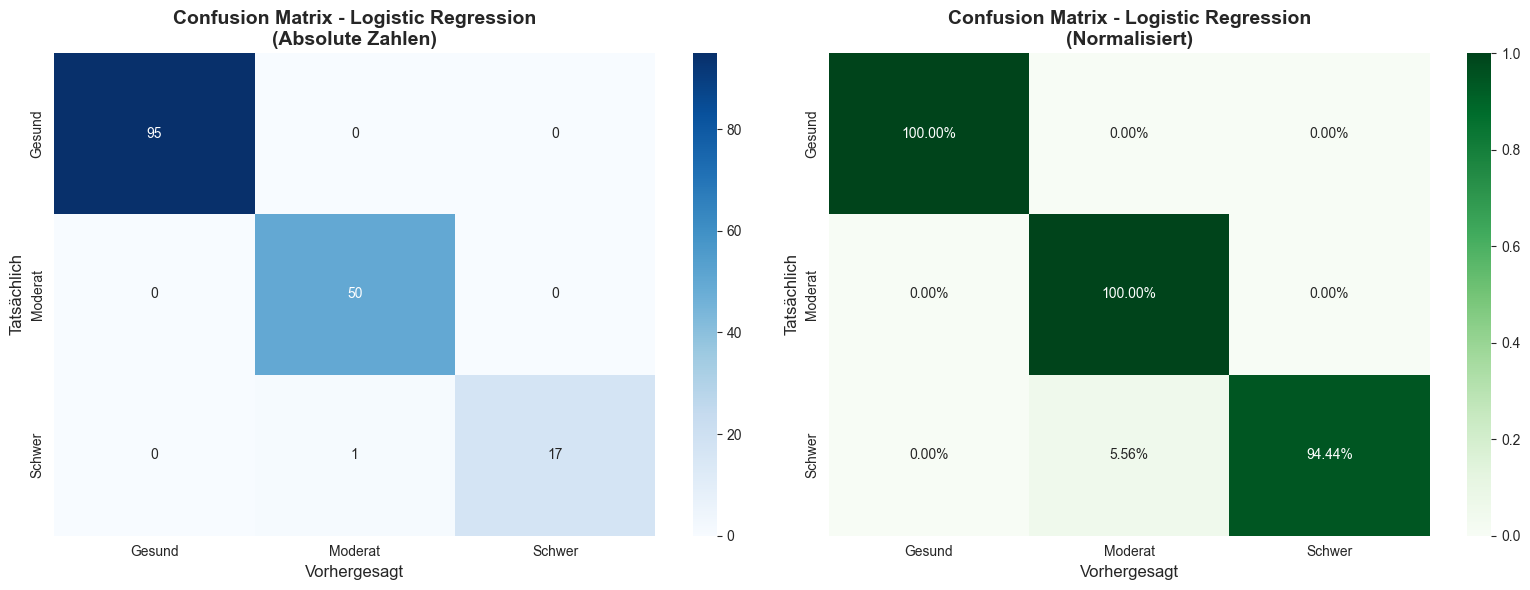

In [17]:
# Confusion Matrix für besten Classifier
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute Zahlen
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Gesund', 'Moderat', 'Schwer'],
            yticklabels=['Gesund', 'Moderat', 'Schwer'])
axes[0].set_xlabel('Vorhergesagt', fontsize=12)
axes[0].set_ylabel('Tatsächlich', fontsize=12)
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Absolute Zahlen)', 
                  fontsize=14, fontweight='bold')

# Normalisiert
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Gesund', 'Moderat', 'Schwer'],
            yticklabels=['Gesund', 'Moderat', 'Schwer'])
axes[1].set_xlabel('Vorhergesagt', fontsize=12)
axes[1].set_ylabel('Tatsächlich', fontsize=12)
axes[1].set_title(f'Confusion Matrix - {best_model_name}\n(Normalisiert)', 
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('05_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Detaillierter Classification Report
print("\n=== DETAILLIERTER CLASSIFICATION REPORT ===")
print("="*70)
target_names = ['Gesund (0)', 'Moderat (1)', 'Schwer (2)']
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                           target_names=target_names, digits=3))


=== DETAILLIERTER CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

  Gesund (0)      1.000     1.000     1.000        95
 Moderat (1)      0.980     1.000     0.990        50
  Schwer (2)      1.000     0.944     0.971        18

    accuracy                          0.994       163
   macro avg      0.993     0.981     0.987       163
weighted avg      0.994     0.994     0.994       163



In [19]:
# Klassenspezifische Metriken berechnen
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, results[best_model_name]['y_pred'], average=None
)

# Sensitivity und Specificity pro Klasse
print("\n=== KLASSENSPEZIFISCHE METRIKEN ===")
print("="*70)

for i, label in enumerate(['Gesund', 'Moderat belastet', 'Schwer belastet']):
    # True Positives, False Positives, False Negatives, True Negatives
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n{label} (Klasse {i}):")
    print(f"  Anzahl im Test-Set:  {support[i]}")
    print(f"  Precision:           {precision[i]:.3f}")
    print(f"  Recall (Sensitivity):{sensitivity:.3f}")
    print(f"  Specificity:         {specificity:.3f}")
    print(f"  F1-Score:            {f1[i]:.3f}")
    print(f"  TP={tp}, FP={fp}, FN={fn}, TN={tn}")


=== KLASSENSPEZIFISCHE METRIKEN ===

Gesund (Klasse 0):
  Anzahl im Test-Set:  95
  Precision:           1.000
  Recall (Sensitivity):1.000
  Specificity:         1.000
  F1-Score:            1.000
  TP=95, FP=0, FN=0, TN=68

Moderat belastet (Klasse 1):
  Anzahl im Test-Set:  50
  Precision:           0.980
  Recall (Sensitivity):1.000
  Specificity:         0.991
  F1-Score:            0.990
  TP=50, FP=1, FN=0, TN=112

Schwer belastet (Klasse 2):
  Anzahl im Test-Set:  18
  Precision:           1.000
  Recall (Sensitivity):0.944
  Specificity:         1.000
  F1-Score:            0.971
  TP=17, FP=0, FN=1, TN=145


## 3.2 Decision Boundaries Visualisierung

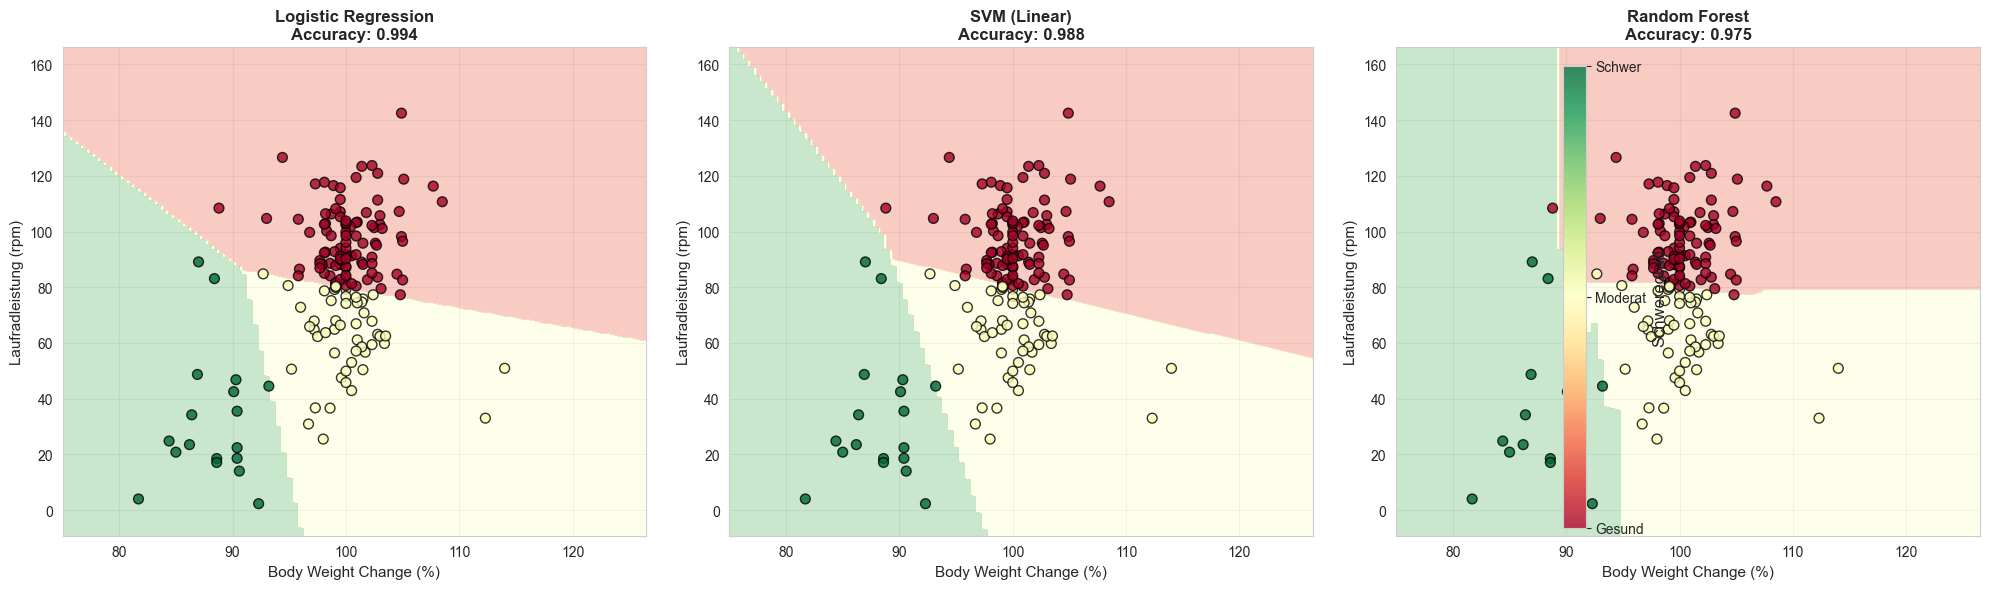

In [20]:
# Decision Boundaries für alle drei Classifier visualisieren
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Mesh-Grid für Decision Boundary
h = 0.5  # Schrittweite
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

for idx, (name, result) in enumerate(results.items()):
    # Vorhersagen für jeden Punkt im Mesh
    Z = result['model'].predict(scaler_clf.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    # Contour Plot
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn', levels=[-.5, 0.5, 1.5, 2.5])
    
    # Datenpunkte
    scatter = axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                                cmap='RdYlGn', edgecolors='black', s=50, alpha=0.8)
    
    axes[idx].set_xlabel('Body Weight Change (%)', fontsize=11)
    axes[idx].set_ylabel('Laufradleistung (rpm)', fontsize=11)
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# Gemeinsame Colorbar
cbar = plt.colorbar(scatter, ax=axes, ticks=[0, 1, 2], pad=0.02)
cbar.set_label('Schweregrad', fontsize=12)
cbar.ax.set_yticklabels(['Gesund', 'Moderat', 'Schwer'])

plt.tight_layout()
plt.savefig('06_decision_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.3 ROC-Kurven für Multi-Class Klassifikation

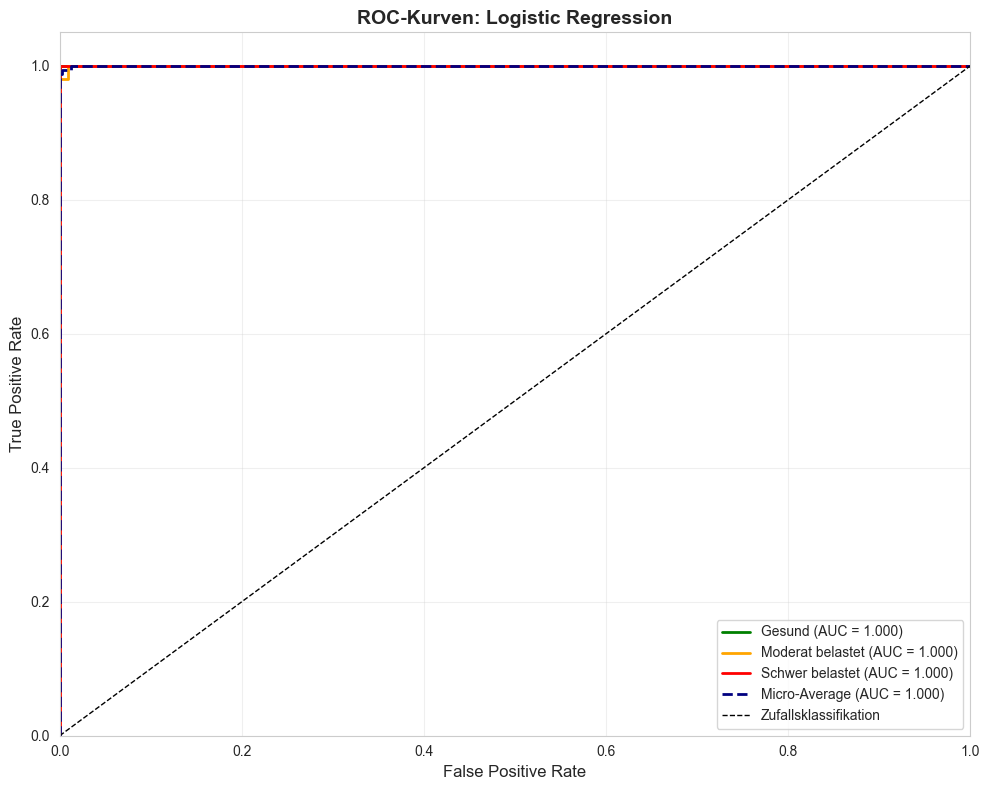


=== ROC AUC SCORES ===
Gesund: 1.000
Moderat belastet: 1.000
Schwer belastet: 1.000
Micro-Average: 1.000


In [21]:
# ROC-Kurven für den besten Classifier (One-vs-Rest)
from sklearn.preprocessing import label_binarize

# Binarisierung für Multi-Class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Wahrscheinlichkeiten für jede Klasse
y_score = best_model.predict_proba(X_test_scaled)

# ROC-Kurve für jede Klasse berechnen
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Visualisierung
plt.figure(figsize=(10, 8))

colors = ['green', 'orange', 'red']
labels = ['Gesund', 'Moderat belastet', 'Schwer belastet']

for i, color, label in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr["micro"], tpr["micro"], color='navy', lw=2, linestyle='--',
         label=f'Micro-Average (AUC = {roc_auc["micro"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Zufallsklassifikation')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC-Kurven: {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== ROC AUC SCORES ===")
for i, label in enumerate(labels):
    print(f"{label}: {roc_auc[i]:.3f}")
print(f"Micro-Average: {roc_auc['micro']:.3f}")

## 3.4 Feature Importance & Model Interpretation

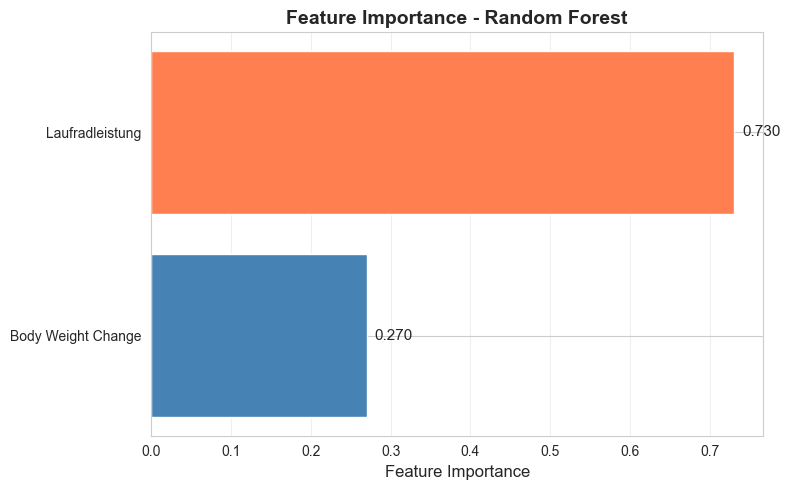


Body Weight Change Importance: 0.270
Laufradleistung Importance: 0.730


In [22]:
# Feature Importance für Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_
    feature_names = ['Body Weight Change', 'Laufradleistung']
    
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names, importances, color=['steelblue', 'coral'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(importances):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('08_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nBody Weight Change Importance: {importances[0]:.3f}")
    print(f"Laufradleistung Importance: {importances[1]:.3f}")

In [23]:
# Koeffizienten für Logistic Regression
if 'Logistic Regression' in results:
    lr_model = results['Logistic Regression']['model']
    
    print("\n=== LOGISTIC REGRESSION KOEFFIZIENTEN ===")
    print("="*70)
    
    for i, class_label in enumerate(['Gesund', 'Moderat', 'Schwer']):
        coef = lr_model.coef_[i]
        intercept = lr_model.intercept_[i]
        
        print(f"\n{class_label}:")
        print(f"  BWC Koeffizient:  {coef[0]:>8.4f}")
        print(f"  VWR Koeffizient:  {coef[1]:>8.4f}")
        print(f"  Intercept:        {intercept:>8.4f}")
        print(f"  → Formel: {intercept:.4f} + {coef[0]:.4f}*BWC + {coef[1]:.4f}*VWR")


=== LOGISTIC REGRESSION KOEFFIZIENTEN ===

Gesund:
  BWC Koeffizient:    2.0150
  VWR Koeffizient:    5.8736
  Intercept:          1.8662
  → Formel: 1.8662 + 2.0150*BWC + 5.8736*VWR

Moderat:
  BWC Koeffizient:    1.0215
  VWR Koeffizient:   -2.2873
  Intercept:          2.1505
  → Formel: 2.1505 + 1.0215*BWC + -2.2873*VWR

Schwer:
  BWC Koeffizient:   -3.0365
  VWR Koeffizient:   -3.5864
  Intercept:         -4.0168
  → Formel: -4.0168 + -3.0365*BWC + -3.5864*VWR


## 3.5 Cross-Validation Details

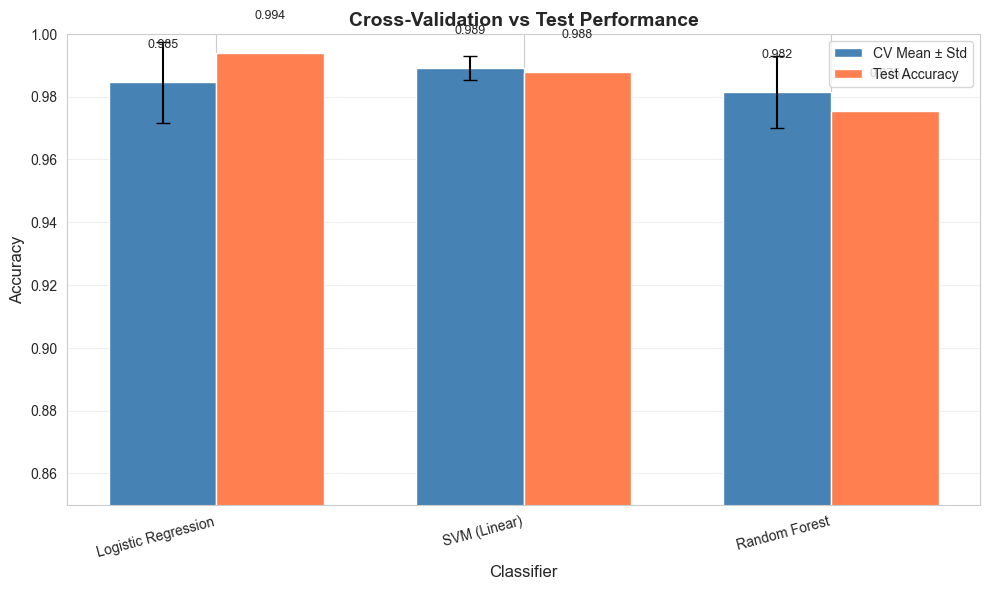


=== CROSS-VALIDATION ZUSAMMENFASSUNG ===
              Model  CV Mean   CV Std  Test Accuracy
Logistic Regression 0.984615 0.012872       0.993865
       SVM (Linear) 0.989231 0.003768       0.987730
      Random Forest 0.981538 0.011513       0.975460


In [24]:
# Visualisierung der Cross-Validation Ergebnisse
cv_results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Mean': [r['cv_mean'] for r in results.values()],
    'CV Std': [r['cv_std'] for r in results.values()],
    'Test Accuracy': [r['accuracy'] for r in results.values()]
})

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(cv_results_df))
width = 0.35

bars1 = ax.bar(x - width/2, cv_results_df['CV Mean'], width, 
               yerr=cv_results_df['CV Std'], label='CV Mean ± Std',
               color='steelblue', capsize=5)
bars2 = ax.bar(x + width/2, cv_results_df['Test Accuracy'], width,
               label='Test Accuracy', color='coral')

ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Cross-Validation vs Test Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cv_results_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.85, 1.0])

# Werte auf Balken schreiben
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('09_cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== CROSS-VALIDATION ZUSAMMENFASSUNG ===")
print(cv_results_df.to_string(index=False))

## 3.6 Zusammenfassung und Fazit

In [25]:
print("\n" + "="*70)
print("ZUSAMMENFASSUNG DER ANALYSE")
print("="*70)

print("\n1. DATENCHARAKTERISIERUNG:")
print("   ✓ Dosisabhängige Unterschiede wurden statistisch nachgewiesen")
print("   ✓ Laufradleistung reagiert sensitiver als Körpergewicht")
print("   ✓ Höhepunkt der Entzündung: Tag 7-9")

print("\n2. MACHINE LEARNING KLASSIFIKATION:")
print(f"   ✓ K-Means Clustering identifizierte 3 objektive Kategorien")
print(f"   ✓ Bester Classifier: {best_model_name}")
print(f"   ✓ Test Accuracy: {results[best_model_name]['accuracy']:.1%}")
print(f"   ✓ Cross-Validation: {results[best_model_name]['cv_mean']:.1%} ± {results[best_model_name]['cv_std']:.1%}")

print("\n3. STATISTISCHE METRIKEN:")
print(f"   ✓ Weighted Precision: {results[best_model_name]['precision']:.3f}")
print(f"   ✓ Weighted Recall:    {results[best_model_name]['recall']:.3f}")
print(f"   ✓ Weighted F1-Score:  {results[best_model_name]['f1']:.3f}")
print(f"   ✓ ROC AUC (Micro):    {roc_auc['micro']:.3f}")

print("\n4. INTERPRETATION:")
print("   • Der Classifier kann Belastungszustände zuverlässig erkennen")
print("   • Beide Features (BWC + VWR) tragen zur Klassifikation bei")
print("   • Lineare Trennlinien sind ausreichend für gute Performance")
print("   • Modell generalisiert gut (ähnliche CV- und Test-Performance)")

print("\n" + "="*70)
print("ALLE ANALYSEN ERFOLGREICH ABGESCHLOSSEN")
print("="*70)


ZUSAMMENFASSUNG DER ANALYSE

1. DATENCHARAKTERISIERUNG:
   ✓ Dosisabhängige Unterschiede wurden statistisch nachgewiesen
   ✓ Laufradleistung reagiert sensitiver als Körpergewicht
   ✓ Höhepunkt der Entzündung: Tag 7-9

2. MACHINE LEARNING KLASSIFIKATION:
   ✓ K-Means Clustering identifizierte 3 objektive Kategorien
   ✓ Bester Classifier: Logistic Regression
   ✓ Test Accuracy: 99.4%
   ✓ Cross-Validation: 98.5% ± 1.3%

3. STATISTISCHE METRIKEN:
   ✓ Weighted Precision: 0.994
   ✓ Weighted Recall:    0.994
   ✓ Weighted F1-Score:  0.994
   ✓ ROC AUC (Micro):    1.000

4. INTERPRETATION:
   • Der Classifier kann Belastungszustände zuverlässig erkennen
   • Beide Features (BWC + VWR) tragen zur Klassifikation bei
   • Lineare Trennlinien sind ausreichend für gute Performance
   • Modell generalisiert gut (ähnliche CV- und Test-Performance)

ALLE ANALYSEN ERFOLGREICH ABGESCHLOSSEN
